<img src=".\img\mioti.png">   


# Proyecto Reconocimiento Facial: EDA

<img src="./img/emociones.png" style="width: 800px">

### Ojetivos

* El objetivo del proyecto es elaborar un modelo que sea capaz de identificar personas concretas y sus emociones en tiempo real
* Para llevar a cabo esta idea vamos a recurrir a un dataset que contiene más de 35000 fotografías catalogadas por emoción
* A continuación pasaremos a la descarga, visualiación y análisis de nuestros datos y veremos si es necesario realizar algún tipo de preprocesamiento antes de pasar a la elaboración de nuestra red neuronal

### Importación de librerías

* Las librerías que vamos a utilizar son:
    * pandas: para trabajar con dataframes
    * numpy: para realizar operaciones con arrays
    * matplotlib: para la visualización de imágenes y gráficos
    * PIL: para convertir arrays en imágenes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

### Descarga y análisis de la información

* Vamos a utilizar un dataset llamado 'fer2013' que nos facilitará la información sobre las emociones. A continuación pasaremos a la descarga y visualización de su contenido

In [2]:
#Se crea fórmula para la descarga de datos y el diccionario de emociones

def load_data(path='./Data/fer2013.csv'):
    fer2013 = pd.read_csv(path)
    emotion_mapping = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

    return fer2013, emotion_mapping

In [3]:
#Descargamos los datos

data, emotion=load_data()

In [4]:
#Hacemos una visualización previa

data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
#Revisamos la información del dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


* Tras visualizar el dataset vemos que nuestros datos estan configurados en 3 campos diferentes.
    * emotion: Emoción codificada
    * pixels: Vector con los datos de la imagen
    * Usage: Uso que va a tener el registro (entrenamiento, validación, prueba)
* El siguiente paso que vamos a seguir es descodificar las emociones en su atributo, para ello generaremos un nuevo campo en el dataset

In [6]:
#Visualizamos el diccionario de emociones

emotion

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

In [7]:
#Creamos una lista de las clases del dataframe en función de su uso

usage=data.Usage.unique()
usage

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [8]:
#Creamos una nueva variable con el atributo de las emociones a través de un mapeo

data['emotions']=data['emotion'].map(emotion)
data.head()

,emotion,pixels,Usage,emotions
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,Angry
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,Angry
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,Fear
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,Sad
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,Neutral


### Visualización de los datos

* Vamos a ver cómo estan distribuidas las diferentes clases en cada uso para verificar si existe algún tipo de desbalanceo

In [9]:
#Agrupamos los datos según las emociones y el tipo de uso 

df=data.pivot_table(index='emotions',columns='Usage',aggfunc='count',margins=True).emotion
df=df.drop('All',axis=0)
df

Usage,PrivateTest,PublicTest,Training,All
emotions,,,,
Angry,491,467,3995,4953
Disgust,55,56,436,547
Fear,528,496,4097,5121
Happy,879,895,7215,8989
Neutral,626,607,4965,6198
Sad,594,653,4830,6077
Surprise,416,415,3171,4002


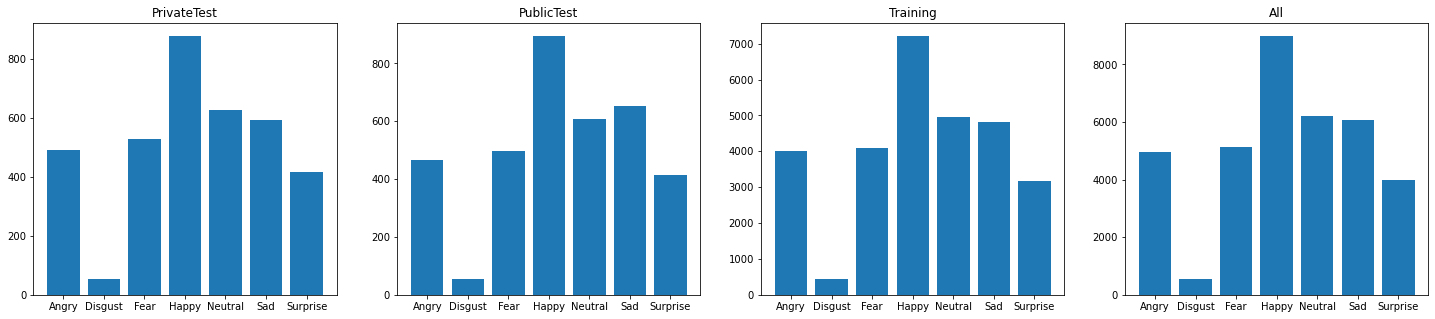

In [10]:
#Graficamos las emociones por cada tipo de uso

fig,ax=plt.subplots(1,4,figsize=(25,5))
for i in range(4):
    ax[i].bar(df.index,df.iloc[:,i])
    ax[i].set_title(df.columns[i])
plt.show()

* Si nos fijamos en los gráficos entre usos, vemos que las clases en los diferentes tipos (entrenamiento, validación y test) son bastantes similares. En todos los usos la clase 'disgust' es claramente minoritaria mientras que 'happy' esta bastante por encima de las demás, el resto de las clases se mantienen más o menos equilibradas

* Vamos a eliminar las variables 'Disgust' y 'Happy' que son las que desbalancean el dataset y a ver cuál es la media de imágenes del resto de las clases y vamos a ver cuántas imágenes deberíamos incluir en el campo 'Disgust' para eliminar el desbalanceo

In [11]:
Disgust=df.loc['Disgust']
Disgust

Usage
PrivateTest     55
PublicTest      56
Training       436
All            547
Name: Disgust, dtype: int64

In [12]:
df=df.drop(['Disgust','Happy'],axis=0)
df.describe()

Usage,PrivateTest,PublicTest,Training,All
count,5.000000,5.000000,5.000000,5.000000
mean,531.000000,527.600000,4211.600000,5270.200000
std,83.408633,99.220966,723.347634,900.409185
min,416.000000,415.000000,3171.000000,4002.000000
25%,491.000000,467.000000,3995.000000,4953.000000
50%,528.000000,496.000000,4097.000000,5121.000000
75%,594.000000,607.000000,4830.000000,6077.000000
max,626.000000,653.000000,4965.000000,6198.000000


In [13]:
df.mean()-Disgust

Usage
PrivateTest     476.0
PublicTest      471.6
Training       3775.6
All            4723.2
dtype: float64

* Como vemos arriba, tendríamos que ampliar el campo 'Disgust' en casi 4600 imágenes

### Visualización de imágenes

* Por último vamos a visualizar algunas de las imágenes de cada emoción, para ello será necesario transformar el campo pixels primero en un array y posteriormente en imagen

In [14]:
images=[]
labels=[]
#Recorremos los valores de las emociones
for emo in emotion.values():
    #Filtramos el dataset por emoción
    df=data[data.emotions==emo]
    #Vamos a quedarnos con los 10 primeros registro de cada emoción
    for i in range(10):
        #Convertimos los registros de pixels en arrays
        image=np.array(df.pixels.iloc[i].split(' ')).reshape(48,48).astype('float32')
        #Usamos la librería PIL para convertir el vector en una imagen
        image=Image.fromarray(image)
        image=image.convert('L')
        images.append(image)
        labels.append(emo)

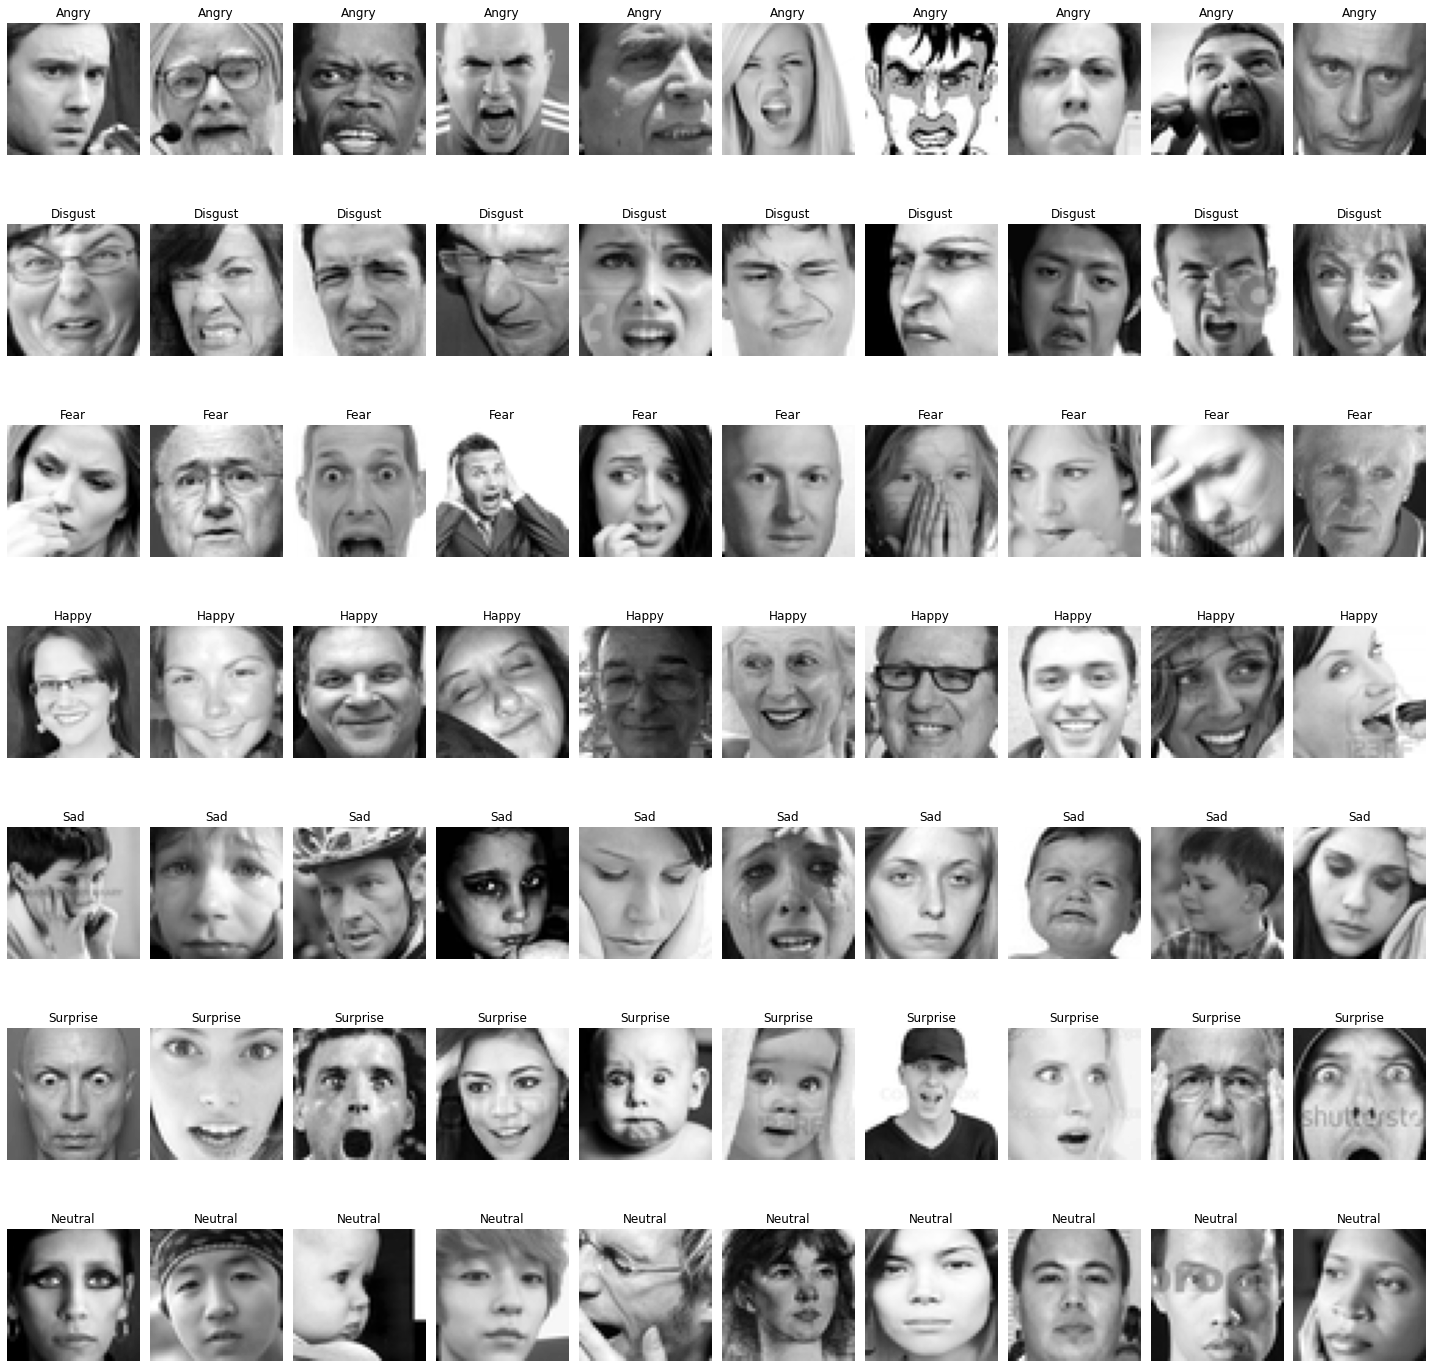

In [15]:
#Definimos las filas, columnas y la figura donde vamos a insertar las imágenes
row=7
col=10
axes=[]
fig=plt.figure(figsize=(20,20))
#Recorremos la figura añadiendo en cada recuadro una imagen con su etiqueta
for i in range(row*col):
    img=images[i]
    lab=labels[i]
    axes.append(fig.add_subplot(row,col,i+1))
    axes[-1].set_title(lab)
    plt.imshow(img,cmap='gray')
    plt.axis("off")
fig.tight_layout()    
plt.show()

* Tras la visualización previa de las emociones parece que algunas de ellas pueden confundise con otras, por ejemplo algunas imágenes de 'Disgust' podrían pasar por 'Angry' y otras por 'Sad'. Algo parecido sucede con 'Fear' que en ocasiones podría confundirse con 'Surprise'. Por otro lado la clase 'Neutral' parece que será la predominante en las predicciones por las características de sus imágenes